In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#from __future__ import division
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import scale, StandardScaler

from sklearn.dummy import DummyClassifier

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import validation_curve

## Import the Dataset

In [3]:
#open and read the file into a pandas data frame
#read data in from pickle file
df_orig = pd.read_pickle('DDC_model_data.pkl')

In [4]:
#view the dataset
df_orig.head()

,ProjectId,Construction,DivisionName,UnitName,Borough,Priority,MultipleFMSIds,DesignFiscalYear,ConstructionFiscalYear,Sponsor_Aging,...,ConstructionContractType_None,ConstructionContractType_Pass Through,ConstructionContractType_Requirement Contract,ConstructionContractType_Requirements TO,ConstructionContractType_Standard Consultant,ConstructionContractType_Standard Design/Const.,ConstructionContractType_MissingValue,SourceSystem_PIMS,SourceSystem_Project Info,SourceSystem_MissingValue
0,ACEDOS501,241.0,Public Buildings,ONENYC,Unknown,Standard,FALSE,MissingValue,MissingValue,0,...,0,0,0,0,0,0,0,1,0,0
4,ACSLSPCAR,400.0,Public Buildings,CORRECTIONS,Brooklyn,Emergency,FALSE,MissingValue,MissingValue,0,...,0,0,0,0,0,0,0,1,0,0
6,AGCOVELLO,750.0,Public Buildings,Human Services,MissingValue,Standard,FALSE,MissingValue,MissingValue,1,...,0,0,0,0,0,0,0,1,0,0
13,BEDA001,728.0,Infrastructure,BROOKLYN,Brooklyn,Critical,FALSE,2015,2016,0,...,0,0,0,1,0,0,0,1,0,0
17,C114NEWRIP1,209.0,Public Buildings,Corrections,MissingValue,Standard,FALSE,MissingValue,MissingValue,0,...,0,0,0,0,0,0,0,0,1,0


# Modeling Decisions

In [5]:
#view statistics on the target variable
df_orig.Construction.describe()

count     243.000000
mean      589.094650
std       488.011494
min        14.000000
25%       305.500000
50%       436.000000
75%       734.500000
max      4385.000000
Name: Construction, dtype: float64

** Create a binary 0/1 column based on whether the construction phase exceeds 600 days, rounding up from the 589 days, to predict which projects will exceed this number of days **

In [6]:
df_orig['Construction_600'] = np.where(df_orig.Construction > 600,1,0)

In [7]:
df_orig.head()

,ProjectId,Construction,DivisionName,UnitName,Borough,Priority,MultipleFMSIds,DesignFiscalYear,ConstructionFiscalYear,Sponsor_Aging,...,ConstructionContractType_Pass Through,ConstructionContractType_Requirement Contract,ConstructionContractType_Requirements TO,ConstructionContractType_Standard Consultant,ConstructionContractType_Standard Design/Const.,ConstructionContractType_MissingValue,SourceSystem_PIMS,SourceSystem_Project Info,SourceSystem_MissingValue,Construction_600
0,ACEDOS501,241.0,Public Buildings,ONENYC,Unknown,Standard,FALSE,MissingValue,MissingValue,0,...,0,0,0,0,0,0,1,0,0,0
4,ACSLSPCAR,400.0,Public Buildings,CORRECTIONS,Brooklyn,Emergency,FALSE,MissingValue,MissingValue,0,...,0,0,0,0,0,0,1,0,0,0
6,AGCOVELLO,750.0,Public Buildings,Human Services,MissingValue,Standard,FALSE,MissingValue,MissingValue,1,...,0,0,0,0,0,0,1,0,0,1
13,BEDA001,728.0,Infrastructure,BROOKLYN,Brooklyn,Critical,FALSE,2015,2016,0,...,0,0,1,0,0,0,1,0,0,1
17,C114NEWRIP1,209.0,Public Buildings,Corrections,MissingValue,Standard,FALSE,MissingValue,MissingValue,0,...,0,0,0,0,0,0,0,1,0,0


# Set up the target column

In [8]:
target_col = 'Construction_600'

In [9]:
#rename the dataframe df to make it easier to work with
df = df_orig

In [10]:
#what is the split of the target column
float(format(sum(df.Construction_600)/len(df),'.4f'))

0.358

** We want to catch all projects that might have long project durations even if we catch a few false positives, so we care more about recall ** 

## Identify Features (X) and target (y)

In [11]:
#list(df)

In [12]:
#Identify the feature names
features = [
 'ProjectType_Feasibility Study',
 'ProjectType_New Construction',
 'ProjectType_Other',
 'ProjectType_Ped Ramps',
 'ProjectType_Renovation',
 'ProjectType_Sewer',
 'ProjectType_Sidewalks',
 'ProjectType_Street',
 'ProjectType_Street Reconstruction',
 'ProjectType_Street Resurfacing',
 'ProjectType_Upgrade',
 'ProjectType_Water',
 'ProjectType_MissingValue',
]

In [13]:
#set X and y
X = df.loc[:,features]
y = df.loc[:,[target_col]]

In [14]:
X.head()

,ProjectType_Feasibility Study,ProjectType_New Construction,ProjectType_Other,ProjectType_Ped Ramps,ProjectType_Renovation,ProjectType_Sewer,ProjectType_Sidewalks,ProjectType_Street,ProjectType_Street Reconstruction,ProjectType_Street Resurfacing,ProjectType_Upgrade,ProjectType_Water,ProjectType_MissingValue
0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,1,0
17,0,1,0,0,0,0,0,0,0,0,0,0,0


In [15]:
y.head()

,Construction_600
0,0
4,0
6,1
13,1
17,0


## Split into train, validation, and test sets

In [16]:
#set the random seed
rand = 20

In [17]:
#split data into training and test sets
training_X, test_X, \
training_y, test_y = train_test_split(X, y, test_size=0.2,random_state = rand)

In [18]:
len(training_X), len(test_X)

(194, 49)

In [19]:
len(training_y), len(test_y)

(194, 49)

# Scale the features

In [20]:
#use the training set to create a standard scaler for validation and test sets
#this scaler finds the mean and standard deviation of the train set
scaler = StandardScaler().fit(training_X)

In [21]:
#transform the features for all sets using the scaler created from the train set
#this will subtract the mean to center the data and divide by the standard deviation
#to scale it
training_X_scaled = scaler.transform(training_X)
test_X_scaled = scaler.transform(test_X)
training_X_scaled.shape, test_X_scaled.shape

((194, 13), (49, 13))

** The classes are relatively balanced so there is no need to rebalance in this case **

# Baseline Model

In [22]:
#create the baseline classifier: generates predictions by respecting the training set’s class distribution
clf_B = DummyClassifier(strategy='stratified', random_state=rand)

In [23]:
#fit the regression model
clf_B.fit(test_X_scaled, test_y.iloc[:,0])

DummyClassifier(constant=None, random_state=20, strategy='stratified')

In [24]:
#predict the target values of the validation set using the model
baseline_test_y_pred = clf_B.predict(test_X_scaled)

** Set Baseline metrics on the test set:  
The F1-score takes into account both precision and recall so this will be used as the evaluation metric for all models **

In [25]:
#Evaluate the F1 score: F1 = 2 * (precision * recall) / (precision + recall)
#help(f1_score)
f1_B = float("%.2f" % f1_score(test_y,baseline_test_y_pred))
f1_B

0.39

In [26]:
#calculate precision, recall and accuracy
p_B = float("%.2f" % precision_score(test_y, baseline_test_y_pred))
r_B = float("%.2f" % recall_score(test_y, baseline_test_y_pred))
a_B  = float("%.2f" % accuracy_score(test_y, baseline_test_y_pred))
p_B , r_B,  a_B

(0.39, 0.39, 0.55)

# Initial implementation: Logistic Regression with Scaled Features, No Regularization

In [27]:
#create a logistic regression classifier
#If C is set to 0 that is equivalent to no regularization
clf = LogisticRegression(penalty='l2',C=0.1,random_state=rand)

'''
default values
LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                   class_weight= None, random_state=None, solver=’liblinear’,max_iter=100, 
                   multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)

for imbalanced classes, can adjust class_weight= {0:0.1, 1:0.9}
'''

'\ndefault values\nLogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, \n                   class_weight= None, random_state=None, solver=’liblinear’,max_iter=100, \n                   multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)\n\nfor imbalanced classes, can adjust class_weight= {0:0.1, 1:0.9}\n'

In [28]:
#fit the regression model
clf.fit(training_X_scaled, training_y.iloc[:,0])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=20, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
#get intercept and coefficients
print('Intercept: \n', clf.intercept_)
print('Coefficients: \n', clf.coef_)

Intercept: 
 [-0.50682249]
Coefficients: 
 [[ 0.          0.29779678 -0.08668989 -0.05467236 -0.06635898  0.0493576
  -0.21859604  0.          0.30513793 -0.09277631 -0.16324342  0.13617605
   0.        ]]


# Evaluate the performance of the model on the test set

** Use K-fold Cross Validation to Assess Model Performance and evaluate bias vs variance **

In [30]:
#get the list of the training set sizes
s = 5  # k = 5
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=rand)
m = len(training_X_scaled)  #number of training examples
m_s = m/s*(s-1)
m_s = int(round(m_s,0))
l = range(0,m_s)
train_size = l[0::int(round(m_s/10,0))][1:]
train_size

range(16, 160, 16)

In [31]:
#set up f1_score as a scoring metric
f1_scorer = make_scorer(f1_score)

In [32]:
def learn_curve(model,X,y,train_size):
    #Use full training set (train + validation and implement k-folds)
    #create a learning curve: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_size, cv = cv, scoring = f1_scorer)
    #get the mean of the training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    #plot the chart
    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel("Training examples")
    plt.ylabel("f1_score")
    plt.ticklabel_format(useOffset=False,style='plain')
    
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return float("%.2f" % np.mean(validation_scores_mean))

'''
Notes on underfitting(variance) vs. underfitting(bias)
Overfit - Lines don't quite come together;
Underfit - Lines come together but at too low an F1 score;
Just Right - Lines come together with a reasonable F1 score.

High Bias: f1_score will be low for the training set and the validation set   
High Variance: f1_score will be lower for the validation set than the training set 
Addressing high bias: additional features, adding polynomial features, decreasing the regularization parameter lambda  
Addressing high variance: additional training examples, smaller set of features, increase the regularization parameter lambda
'''

"\nNotes on underfitting(variance) vs. underfitting(bias)\nOverfit - Lines don't quite come together;\nUnderfit - Lines come together but at too low an F1 score;\nJust Right - Lines come together with a reasonable F1 score.\n\nHigh Bias: f1_score will be low for the training set and the validation set   \nHigh Variance: f1_score will be lower for the validation set than the training set \nAddressing high bias: additional features, adding polynomial features, decreasing the regularization parameter lambda  \nAddressing high variance: additional training examples, smaller set of features, increase the regularization parameter lambda\n"

0.42

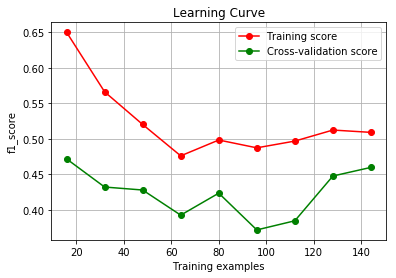

In [33]:
learn_curve(clf, training_X_scaled, training_y.iloc[:,0], train_size)

** The baseline F1 score is 0.39 on the test set, the mean F1 score of the cross validation is 0.42 which is slightly better than the baseline. However the lines don't quite come together which implies overfitting/high variance. Regularization may result in a better model **

# Adjust regularization to account for overfitting
Alpha is the parameter that dictates the strength of the regularization/smoothing

In [34]:
#set up the range for alpha values
alpha_range = np.arange(0.5, 5, 0.5)
alpha_range

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5])

In [35]:
def valid_curve(model,X,y):
    #Use full training set (train + validation and implement k-folds)
    #create a learning curve: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve
    train_scores, validation_scores = validation_curve(
        model, X, y, param_name = "C", 
        param_range = alpha_range, groups=None, cv=cv, 
        scoring= f1_scorer, n_jobs=1, pre_dispatch='all', verbose=0)
    #get the mean of the training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    #plot the chart
    plt.figure()
    plt.title('Validation Curve')
    plt.xlabel("Alpha - regularization strength")
    plt.ylabel("f1_score")
    plt.ticklabel_format(useOffset=False,style='plain')

    plt.grid()

    plt.plot(alpha_range, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(alpha_range, validation_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return float("%.2f" % np.mean(validation_scores_mean))

0.46

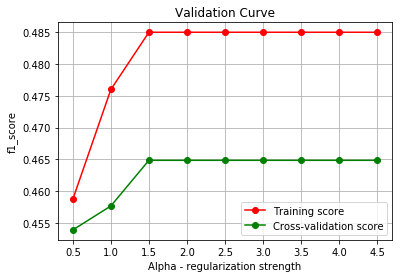

In [36]:
#plot the validation curve with a range of alpha values
valid_curve(clf, training_X, training_y.iloc[:,0].values)

** The mean F2-score is 0.46 for the model with L2 Regularization and an alpha of 1.5, vs. 0.42 for the model without regularization and 0.39 for the baseline. This model appears to be an improvement over the baseline.**

### Final evaluation on the test set

Evaluate the models:  
    Baseline:  F1-score = 0.39, p = 0.39, r = 0.39, a = 0.55  
    Model 1: Logistic regression, no regularization  
    Model 2: Linear with polynomials, L2 regularization, alpha = 1.5  

** Evaluate Model 1 on the test set **

In [37]:
#predict the target values of the validation set using the model
M1_test_y_pred = clf.predict(test_X_scaled)

In [38]:
#Evaluate the MSE on the test set for the best models
float("%.2f" % f1_score(test_y, M1_test_y_pred))

0.29

In [39]:
#calculate precision, recall and accuracy
p1 = float("%.2f" % precision_score(test_y, M1_test_y_pred))
r1 = float("%.2f" % recall_score(test_y, M1_test_y_pred))
a1 = float("%.2f" % accuracy_score(test_y, M1_test_y_pred))
p1 , r1,  a1

(0.4, 0.22, 0.59)

The F1-score is only 0.29, reflecting lower recall. The cross validation indicated that this model was slightly better than the Baseline, but given the result on the test set, it appears that the model is overfitting. A larger number of observations might improve this result.

#### Evaluate Model 2 on the test set

In [40]:
clf2 = LogisticRegression(penalty='l2',C=1.5,random_state=rand)

In [41]:
#fit the regression model
clf2.fit(training_X_scaled, training_y.iloc[:,0])

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=20, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
#predict the target values of the validation set using the model
M2_test_y_pred = clf2.predict(test_X_scaled)

In [43]:
#Evaluate the MSE on the test set for the best models
float("%.2f" % f1_score(test_y, M2_test_y_pred))

0.29

In [44]:
#calculate precision, recall and accuracy
p1 = float("%.2f" % precision_score(test_y, M2_test_y_pred))
r1 = float("%.2f" % recall_score(test_y, M2_test_y_pred))
a1 = float("%.2f" % accuracy_score(test_y, M2_test_y_pred))
p1 , r1,  a1

(0.4, 0.22, 0.59)

The F1-score is only 0.29, reflecting lower recall. The cross validation indicated that this model was slightly better than the Baseline and the model without regularization, but given the result on the test set, it appears that the model is overfitting. A larger number of observations might improve the result.

# Observations

** The F1 score on the test set is lower than the cross validation which implies overfitting. There are other possible models that could be tried but given the small size of the sample dataset these would likely not provide improved results **